## Máster en Data Science - Series Temporales

# ARIMA Model
Autor: Ramón Morillo Barrera

## Dataset: Madrid.csv

En este notebook, se desarrollará un análisis para predecir el número de pasajeros del metro y autobús de Madrid utilizando modelos ARIMA (AutoRegressive Integrated Moving Average), una de las técnicas más populares en el modelado de series temporales. Este enfoque combina componentes de autoregresión, diferenciación para manejar la tendencia, y medias móviles para capturar patrones en los errores residuales, ofreciendo una herramienta para realizar predicciones basadas en datos históricos.

El objetivo es construir un modelo que permita anticipar la demanda de transporte público en la ciudad, lo que puede ser útil para la planificación operativa y la optimización de recursos. A lo largo del análisis, se evaluará el desempeño del modelo con métricas como el MSE, RMSE y MAPE, garantizando que las predicciones sean tanto precisas como interpretables.

In [11]:
# librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sktime.utils.plotting import plot_series
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.transformations.series.boxcox import LogTransformer
from sktime.performance_metrics.forecasting import mean_squared_error, mean_absolute_percentage_error
from math import sqrt
from sktime.utils.plotting import plot_correlations
from sktime.transformations.series.difference import Differencer
from sktime.param_est.stationarity import StationarityADF
from sktime.forecasting.sarimax import SARIMAX


warnings.filterwarnings('ignore')

### Importación de datos

In [2]:
df_autobus_month = pd.read_csv('../data/processed/Madrid_autobus_month.csv')
df_metro_month = pd.read_csv('../data/processed/Madrid_metro_month.csv')
df_combined_month = pd.read_csv('../data/processed/Madrid_combined_month.csv')

df_autobus_trim = pd.read_csv('../data/processed/Madrid_autobus_trim.csv')
df_metro_trim = pd.read_csv('../data/processed/Madrid_metro_trim.csv')
df_combined_trim = pd.read_csv('../data/processed/Madrid_combined_trim.csv')

In [3]:
df_autobus_month = df_autobus_month[['Periodo', 'Total']].set_index('Periodo')
df_autobus_trim = df_autobus_trim[['Periodo', 'Total']].set_index('Periodo')
df_combined_month = df_combined_month[['Periodo', 'Total']].set_index('Periodo')
df_combined_trim = df_combined_trim[['Periodo', 'Total']].set_index('Periodo')
df_metro_month = df_metro_month[['Periodo', 'Total']].set_index('Periodo')
df_metro_trim = df_metro_trim[['Periodo', 'Total']].set_index('Periodo')

### Convertimos datos en formato SKtime

In [4]:
df_autobus_month.index = pd.to_datetime(df_autobus_month.index)
df_autobus_trim.index = pd.to_datetime(df_autobus_trim.index)
df_combined_month.index = pd.to_datetime(df_combined_month.index)
df_combined_trim.index = pd.to_datetime(df_combined_trim.index)
df_metro_month.index = pd.to_datetime(df_metro_month.index)
df_metro_trim.index = pd.to_datetime(df_metro_trim.index)

df_autobus_month = df_autobus_month.resample("M").last()
df_autobus_trim = df_autobus_trim.resample("QE").last()
df_combined_month = df_combined_month.resample("M").last()
df_combined_trim = df_combined_trim.resample("QE").last()
df_metro_month = df_metro_month.resample("M").last()
df_metro_trim = df_metro_trim.resample("QE").last()

In [5]:
df_autobus_month=df_autobus_month['Total'].astype('float64').to_period('M').sort_index()
df_autobus_trim=df_autobus_trim['Total'].astype('float64').to_period('Q').sort_index()
df_combined_month=df_combined_month['Total'].astype('float64').to_period('M').sort_index()
df_combined_trim=df_combined_trim['Total'].astype('float64').to_period('Q').sort_index()
df_metro_month=df_metro_month['Total'].astype('float64').to_period('M').sort_index()
df_metro_trim=df_metro_trim['Total'].astype('float64').to_period('Q').sort_index()

Cabe recalcar que después de el análisis de predicción con modelos ARIMA volveré a guardar los dataframes para tener que evitar realizar este tipo de transformaciones cada vez que importe los datos. Esto facilitará el proceso de realización del proyecto y optimizará la legibilidad de los mismos notebooks.

***
## Series Originales

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Total'>)

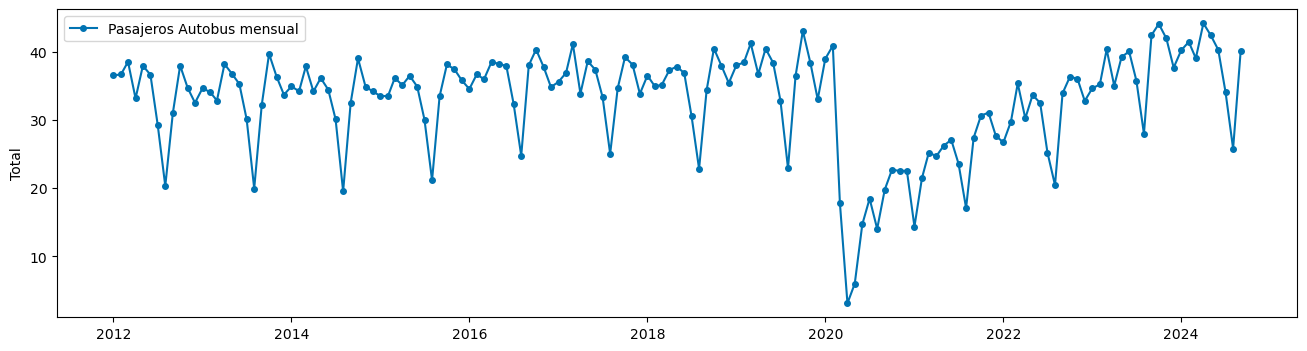

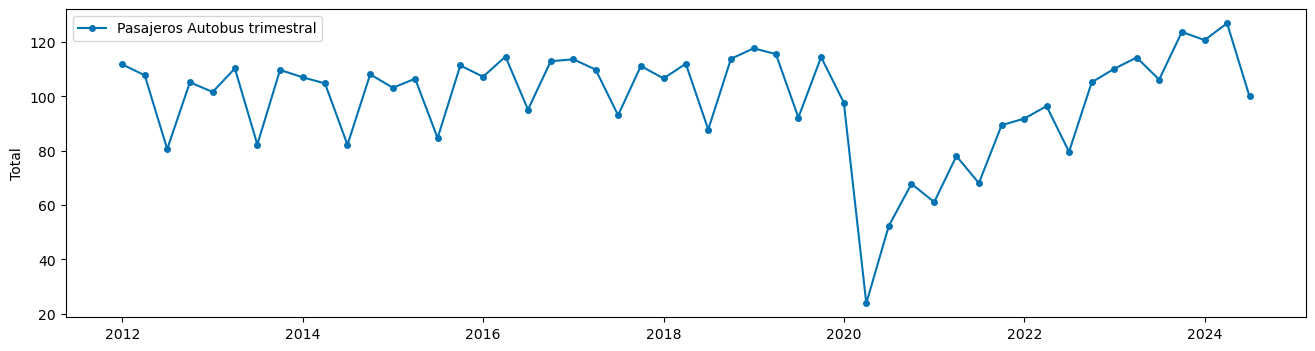

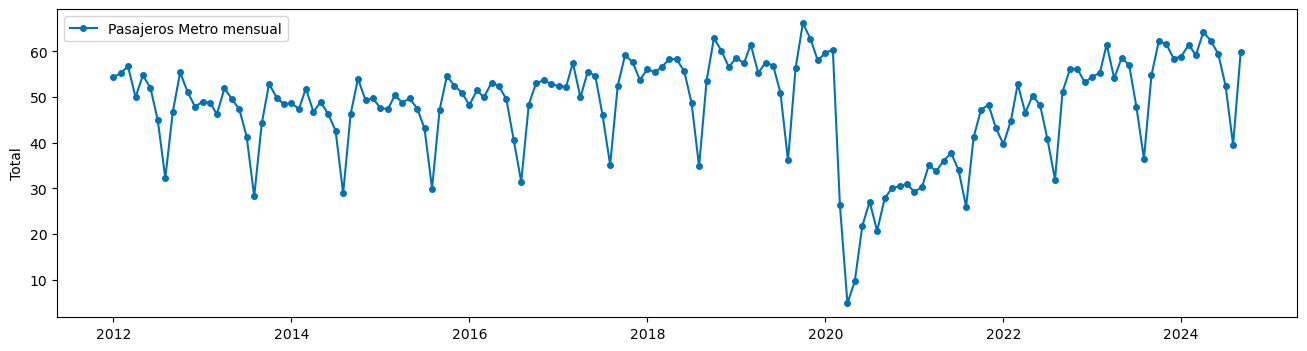

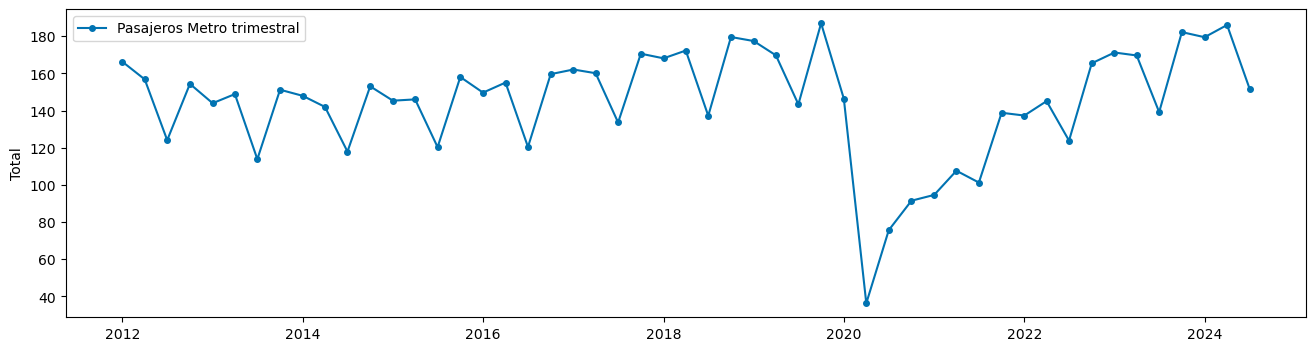

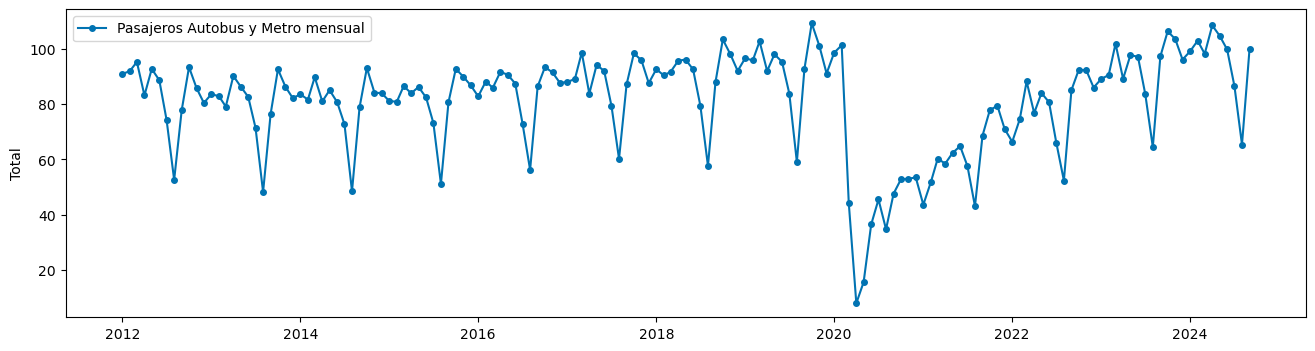

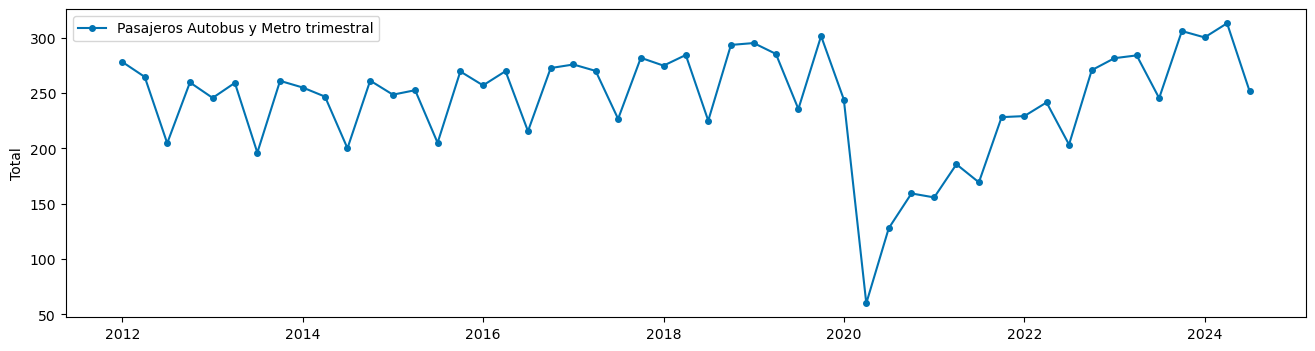

In [6]:
plot_series(df_autobus_month, labels=["Pasajeros Autobus mensual"])
plot_series(df_autobus_trim, labels=["Pasajeros Autobus trimestral"])
plot_series(df_metro_month, labels=["Pasajeros Metro mensual"])
plot_series(df_metro_trim, labels=["Pasajeros Metro trimestral"])
plot_series(df_combined_month, labels=["Pasajeros Autobus y Metro mensual"])
plot_series(df_combined_trim, labels=["Pasajeros Autobus y Metro trimestral"])

Las series temporales, a simple vista la media parece no ser constante a lo largo del tiempo, especialmente entre 2020 y 2022, donde hay un cambio abrupto debido a la pandemia. Esto indica que las series no son estacionarias en la media.

Aunque la variabilidad parece razonablemente constante antes de 2020, el cambio abrupto en 2020-2022 sugiere que la varianza podría no ser uniforme en todo el periodo. Esto también apunta a una falta de estacionariedad en la varianza.

***

## Estacionariedad en varianza

La transformación Box-Cox y la transformación logarítmica son técnicas utilizadas para estabilizar la varianza y hacer que una serie temporal sea más aproximada a la normalidad, lo cual es importante para mejorar el rendimiento de los modelos ARIMA.

Desde un punto de vista de negocio es mejor realizar la estacionariedad en varianza mediante el logaritmo, ya que nos permitirá calcular las tasas de variación logarítmicas. La transformacion Box-Cox no nos permite calcular las tasas de variación.

Desde el punto de vista del estudio de la estacionariedad en media y varianza, únicamente utilizaré la serie temporal combinada de pasajeros de autobús y metro mensual. Esto es porque más tarde crearé un pipeline para predecir todas las series temporales, tanto las mensuales como las trimestrales, con los modelos ARIMA.

### Transformación logarítmica

In [7]:
transformer = LogTransformer()
df_combined_month_log= transformer.fit_transform(df_combined_month)
df_combined_month_log.tail()

2024-05    4.651949
2024-06    4.602898
2024-07    4.460422
2024-08    4.180201
2024-09    4.604720
Freq: M, Name: Total, dtype: float64

Text(0.5, 1.0, 'Pasajeros de autobús y metro Madrid: Transformación LOG')

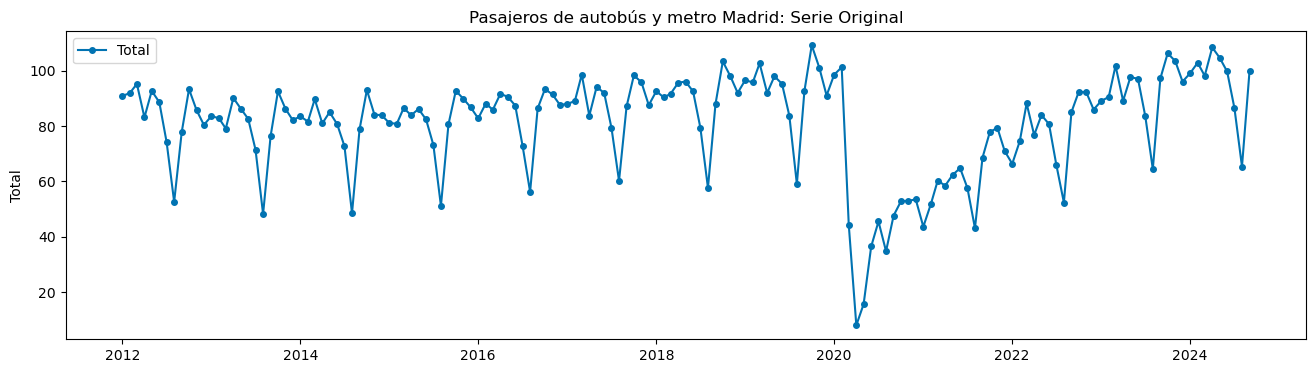

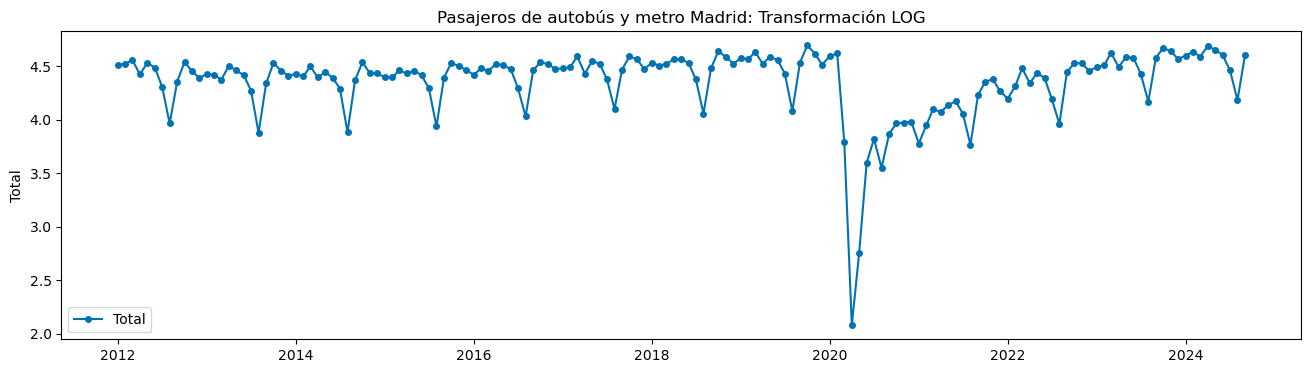

In [8]:
# Plot Log Data & Original Data
fig, ax =plot_series(df_combined_month, labels=["Total"])
ax.set_title('Pasajeros de autobús y metro Madrid: Serie Original')
fig, ax =plot_series(df_combined_month_log, labels=["Total"])
ax.set_title('Pasajeros de autobús y metro Madrid: Transformación LOG')

La transformación logarítmica aplica el logaritmo natural a cada valor de la serie, lo cual reduce la amplitud de las variaciones en los datos, especialmente cuando estos crecen de manera exponencial o tienen una varianza no constante. Al comprimir las diferencias entre valores altos y bajos, esta transformación estabiliza la varianza, facilita la detección de patrones lineales y reduce el impacto de valores extremos o outliers. Sin embargo, solo es aplicable a series con valores positivos, ya que el logaritmo no está definido para valores negativos o cero. Es utilizada para preparar datos antes de aplicar modelos ARIMA, donde se requiere que los residuos tengan varianza constante y sigan una distribución normal.

## Estacionariedad en media


La estacionariedad en media es crucial en el análisis de series temporales porque implica que los valores promedio de la serie no cambian con el tiempo, lo cual facilita la modelación y predicción. En modelos como ARIMA, se asume que la serie temporal tiene propiedades estables en el tiempo, como una media constante, para garantizar que los patrones detectados sean representativos y puedan extrapolarse al futuro. Si la serie no es estacionaria en media, los resultados del modelo pueden ser poco confiables, ya que las tendencias o cambios en la media dificultan capturar la verdadera dinámica del proceso subyacente. Por ello, si se detecta no estacionariedad, se aplican transformaciones como diferenciación o logaritmos para estabilizar la serie y garantizar su idoneidad para el modelado.

### Autocorrelación

Calculamos la autocorrelación de la serie transformada de manera logarítmica.

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Total'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

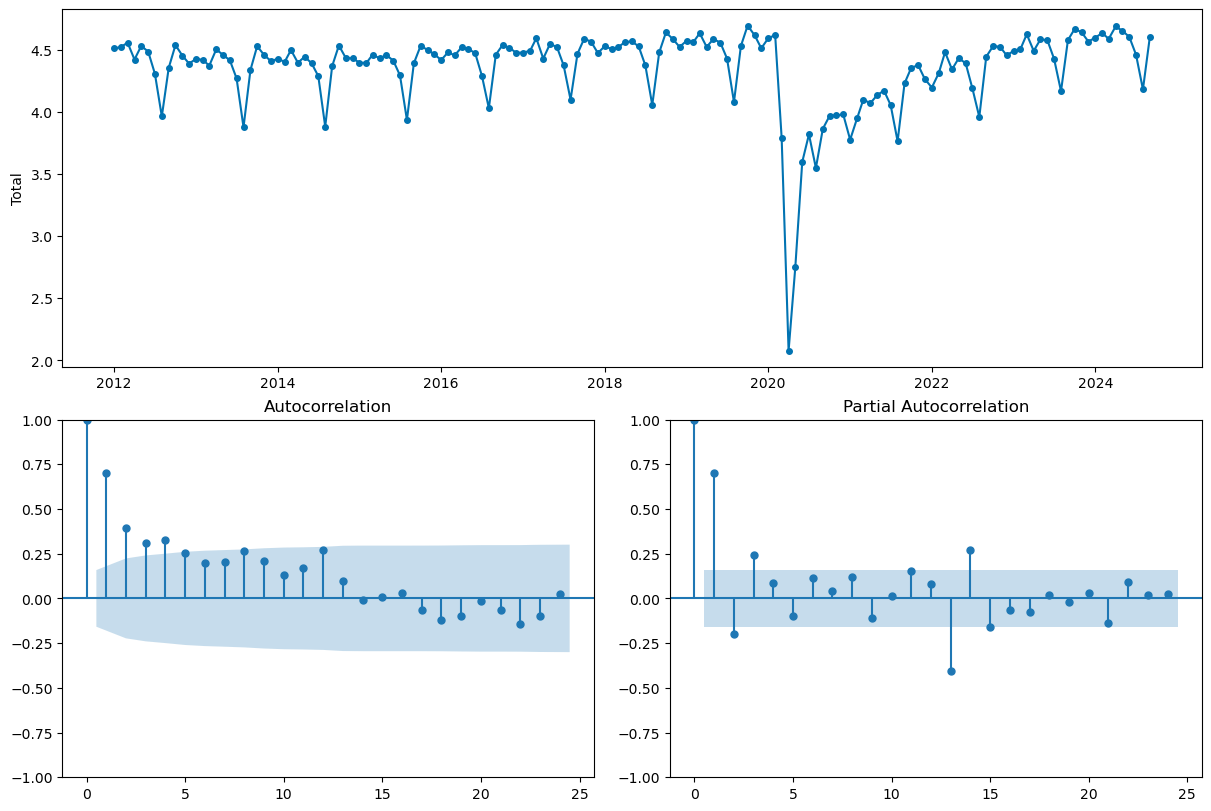

In [10]:
# Autocorrelation Fuction Original Time Series
plot_correlations(df_combined_month_log)

El gráfico de autocorrelación muestra un decrecimiento gradual en los retardos iniciales, lo que indica una fuerte correlación entre los valores recientes de la serie, sugiriendo que aún puede haber una tendencia o estacionalidad en la serie temporal. Además, picos significativos en retardos específicos podrían reflejar componentes estacionales. Por otro lado, el PACF muestra picos significativos en los primeros retardos y luego cae dentro del intervalo de confianza, lo que sugiere que unos pocos términos autorregresivos (AR) podrían ser suficientes para modelar la dinámica de la serie. En conjunto, esto indica que la serie puede requerir diferenciación (posiblemente estacional) para lograr estacionariedad y que un modelo ARIMA podría ser adecuado para capturar sus patrones.

Lo confirmaremos más adelante con las predicciones y las métricas a evaluar.

### Diferenciación

La diferenciación es una técnica fundamental en el análisis de series temporales para convertir una serie no estacionaria en una serie estacionaria, un requisito clave para aplicar modelos ARIMA. Consiste en calcular las diferencias entre valores consecutivos de la serie, lo que elimina tendencias o patrones de crecimiento no lineal que afectan la estabilidad en media y varianza. Esto es especialmente importante porque los modelos ARIMA asumen que las propiedades estadísticas de la serie, como la media y la varianza, son constantes a lo largo del tiempo. Al aplicar la diferenciación, se facilita la identificación de relaciones significativas entre los datos y se mejora la capacidad predictiva del modelo al cumplir con los supuestos de estacionariedad.

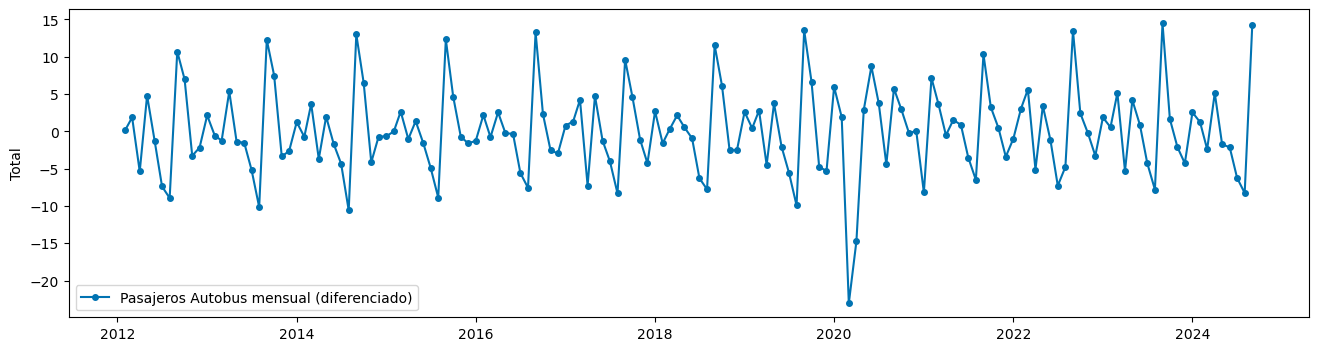

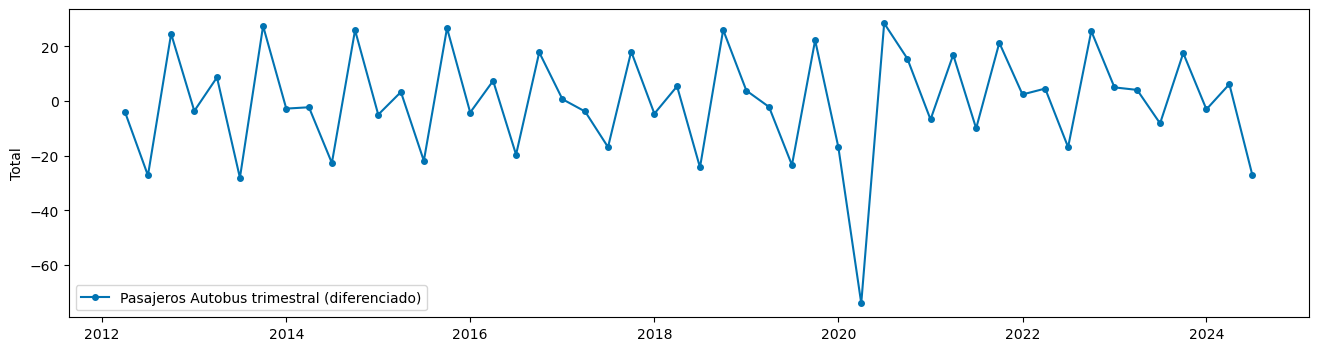

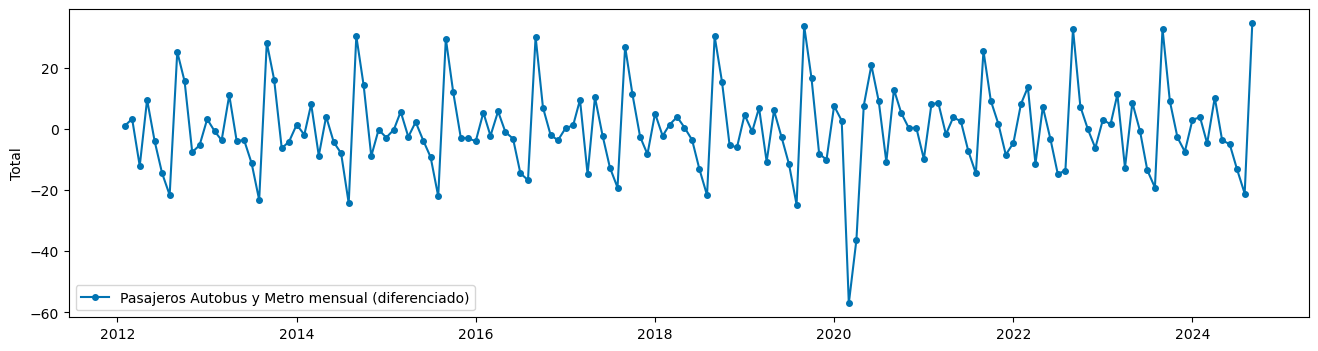

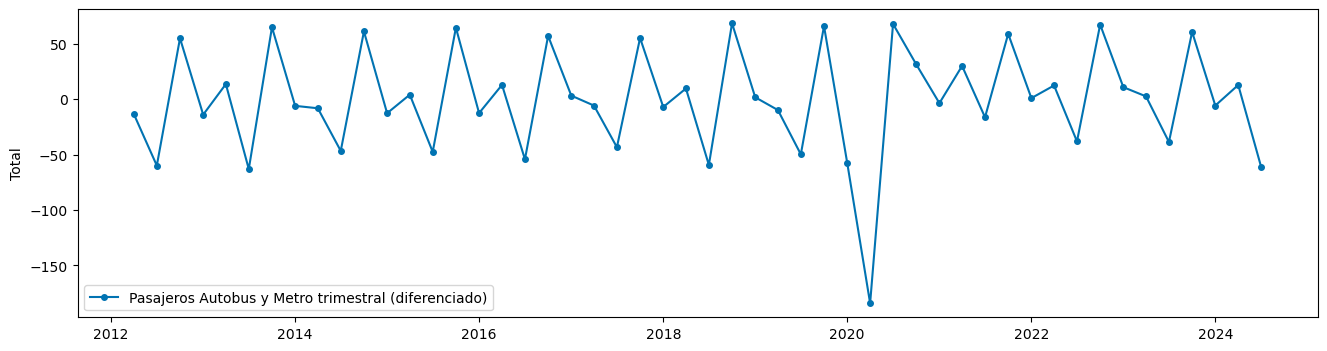

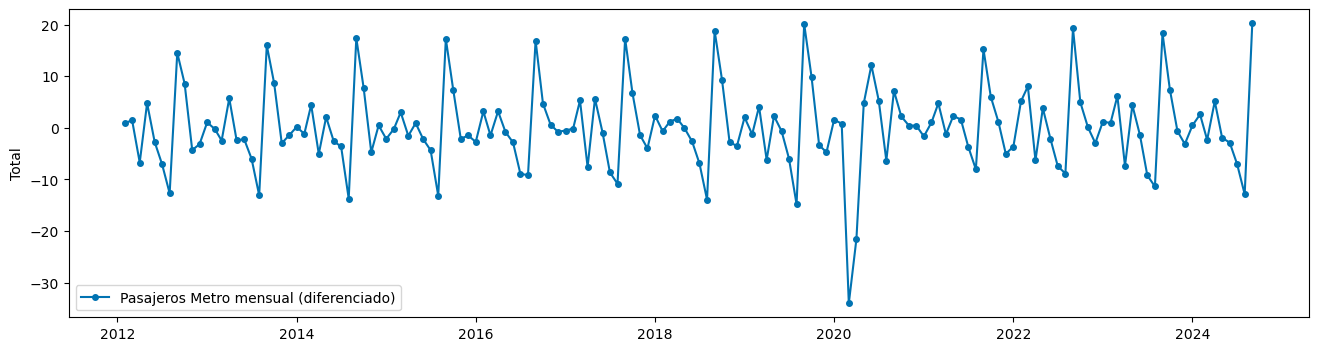

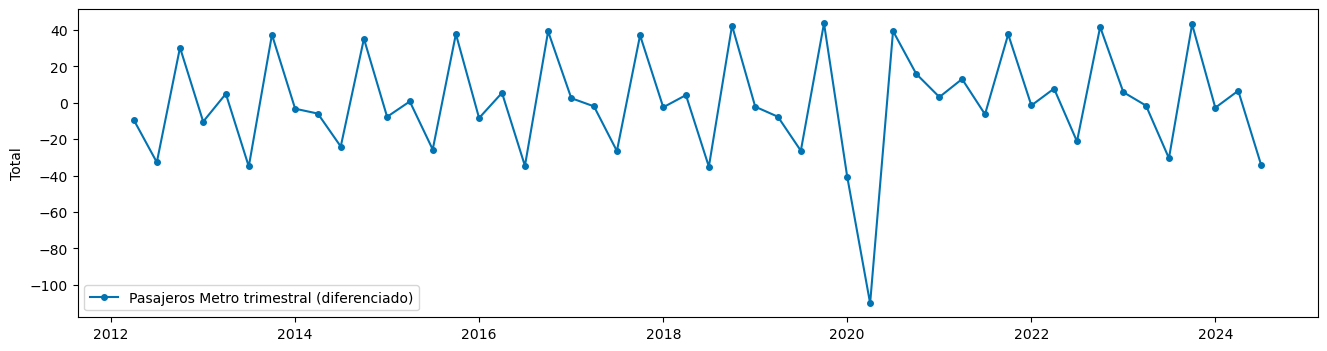

In [19]:
# Diferenciación para establecer estacionariedad en media
df_autobus_month_diff = df_autobus_month.diff().dropna()
df_autobus_trim_diff = df_autobus_trim.diff().dropna()
df_combined_month_diff = df_combined_month.diff().dropna()
df_combined_trim_diff = df_combined_trim.diff().dropna()
df_metro_month_diff = df_metro_month.diff().dropna()
df_metro_trim_diff = df_metro_trim.diff().dropna()

# Visualización de las series diferenciadas
plot_series(df_autobus_month_diff, labels=["Pasajeros Autobus mensual (diferenciado)"])
plot_series(df_autobus_trim_diff, labels=["Pasajeros Autobus trimestral (diferenciado)"])
plot_series(df_combined_month_diff, labels=["Pasajeros Autobus y Metro mensual (diferenciado)"])
plot_series(df_combined_trim_diff, labels=["Pasajeros Autobus y Metro trimestral (diferenciado)"])
plot_series(df_metro_month_diff, labels=["Pasajeros Metro mensual (diferenciado)"])
plot_series(df_metro_trim_diff, labels=["Pasajeros Metro trimestral (diferenciado)"])
plt.show()

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Total'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

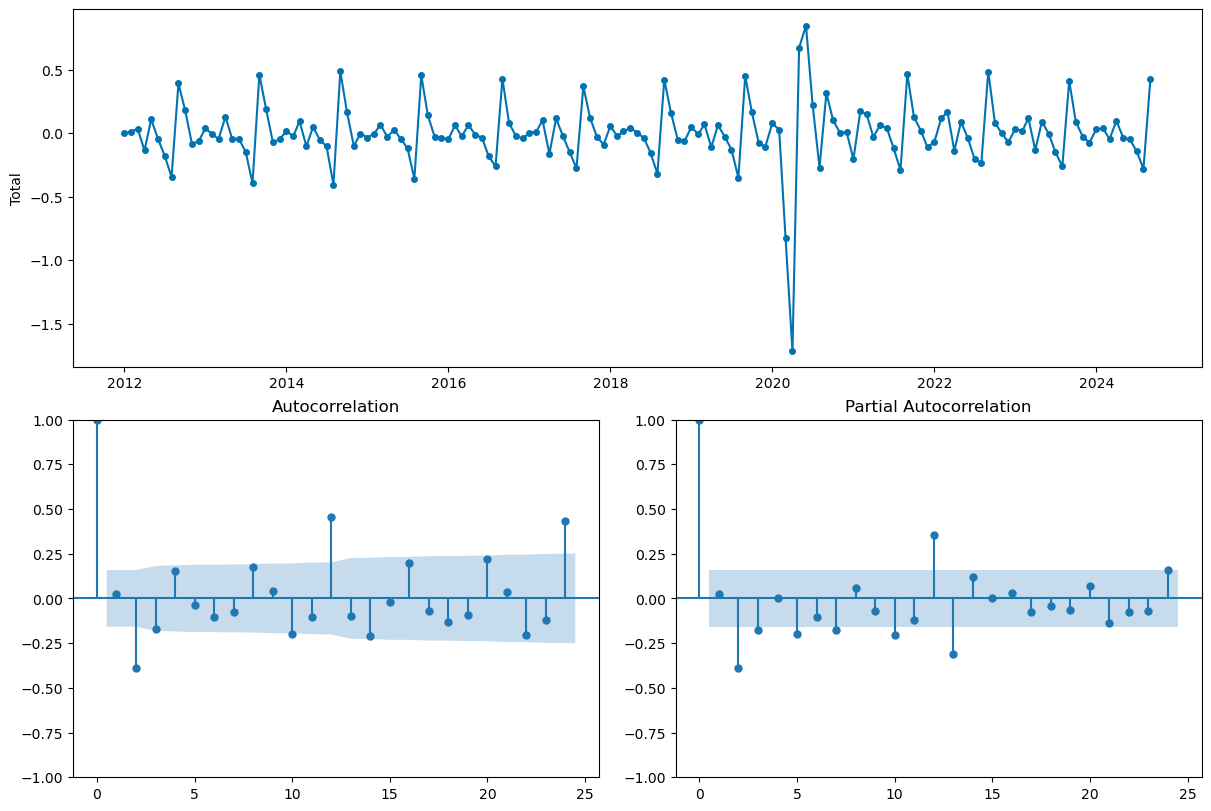

In [12]:
# Autocorrelation Fuction
# d=1; D=0; S=4
# 
transf_diff=Differencer(lags=[1])
plot_correlations(transf_diff.fit_transform(df_combined_month_log))


Aunque la transformación y diferenciación han reducido la no estacionariedad, la serie aún puede no ser completamente estacionaria en media debido a cambios abruptos y patrones persistentes. Sería útil realizar pruebas formales, como la prueba de Dickey-Fuller aumentada (ADF), para confirmar la estacionariedad.

In [13]:
sty_est = StationarityADF()  
sty_est.fit(df_combined_month_log)  
result_adf=sty_est.get_fitted_params(deep=True)
print("ADF Test:")
print(f'Estadístico ADF: {result_adf['test_statistic']}')
print(f'Valor p: {result_adf['pvalue']}')
print(f'Estacionario: {result_adf['stationary']}')
print(f'Número de retardos usados:{result_adf['used_lag']}')

ADF Test:
Estadístico ADF: -2.250412292718283
Valor p: 0.18845976806742598
Estacionario: False
Número de retardos usados:14


Observamos como finalmente la serie temporal no es estacionaria en media.

***

## Pipeline de Modelos ARIMA

Con el objetivo de optimizar el código programado, a continuación usaré un pipeline que realice las transformaciones y entrene los modelos Autoarima con StatsForecast. Se graficará la serie temporal separando en entrenamiento, test y predicción. Tanto para las series temporales mensuales como para las series temporales trimestrales.

Visualizaremos los resultados obtenidos tanto de manera visual como de manera analítica con las métricas MSE, RMSE y MAPE.

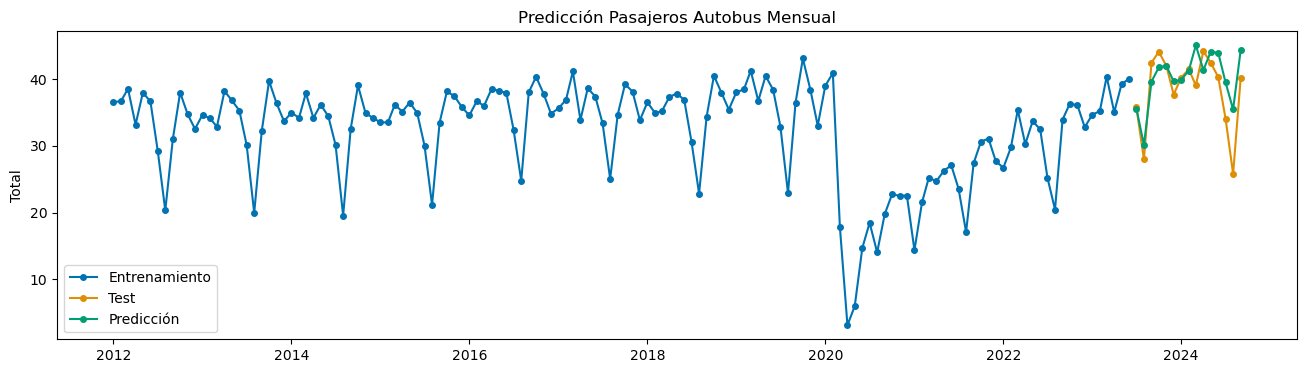

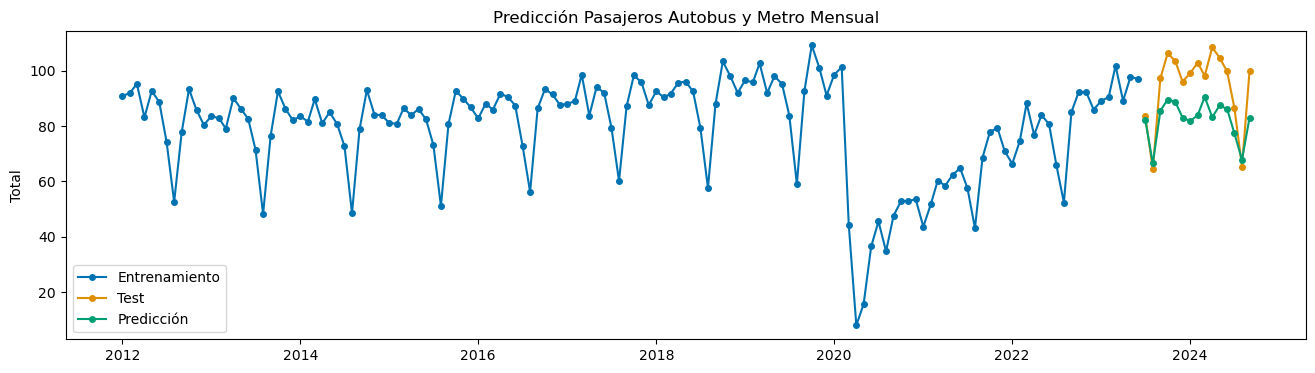

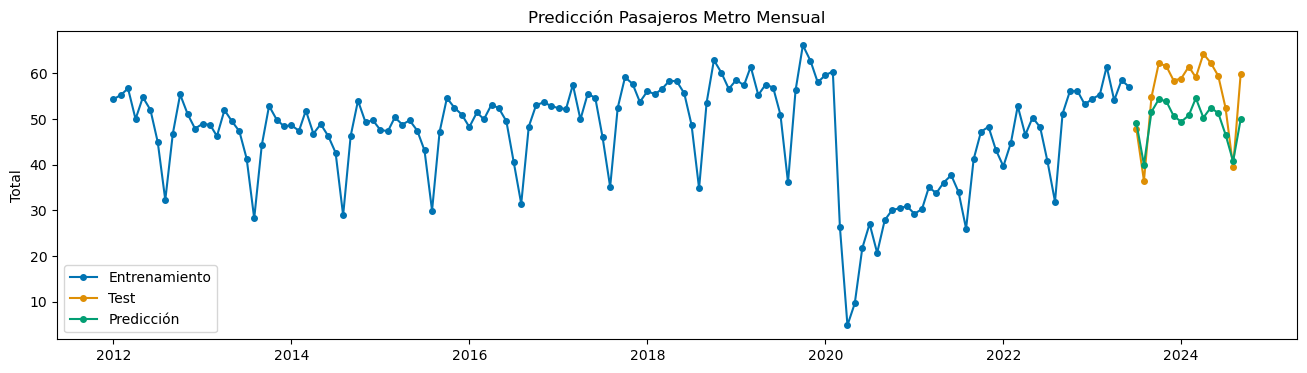

In [15]:
# Definir los parámetros estacionales
sp_params = {
    'mensual': 12,  # Estacionalidad mensual
    'trimestral': 4  # Estacionalidad trimestral
}

# Definir el horizonte de predicción para 15 meses
horizon_15_months = 15

# Crear una función para ajustar el pipeline y predecir
def create_and_forecast_pipeline(y, sp, horizon, title):
    y_train, y_test = temporal_train_test_split(y, test_size=horizon)
    pipeline = TransformedTargetForecaster(steps=[
        ("log", LogTransformer()),  # Transformación Log
        ("autoarima", StatsForecastAutoARIMA(sp=sp))  # Modelo AutoARIMA
    ])
    pipeline.fit(y_train)
    fh = np.arange(1, horizon + 1)
    y_pred = pipeline.predict(fh)
    plot_series(y_train, y_test, y_pred, labels=["Entrenamiento", "Test", "Predicción"])
    plt.title(title)
    plt.show()

# Realizar predicciones y graficar para cada serie temporal mensual
create_and_forecast_pipeline(df_autobus_month, sp_params['mensual'], horizon_15_months, "Predicción Pasajeros Autobus Mensual")
create_and_forecast_pipeline(df_combined_month, sp_params['mensual'], horizon_15_months, "Predicción Pasajeros Autobus y Metro Mensual")
create_and_forecast_pipeline(df_metro_month, sp_params['mensual'], horizon_15_months, "Predicción Pasajeros Metro Mensual")


La predicción de la serie mensual de pasajeros de autobús parece ser buena en casi todo el periodo, la de metro y combinada parece ser buena al inicio y final pero no en los meses centrales.

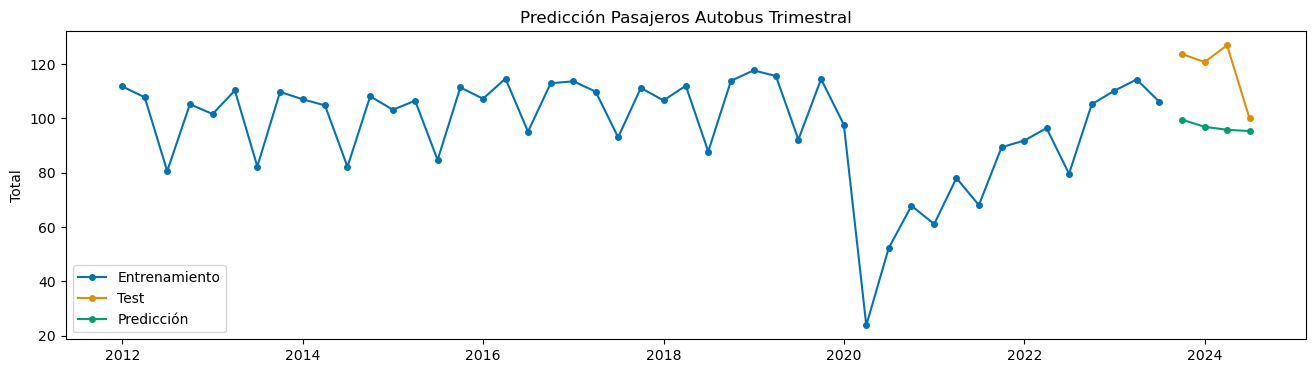

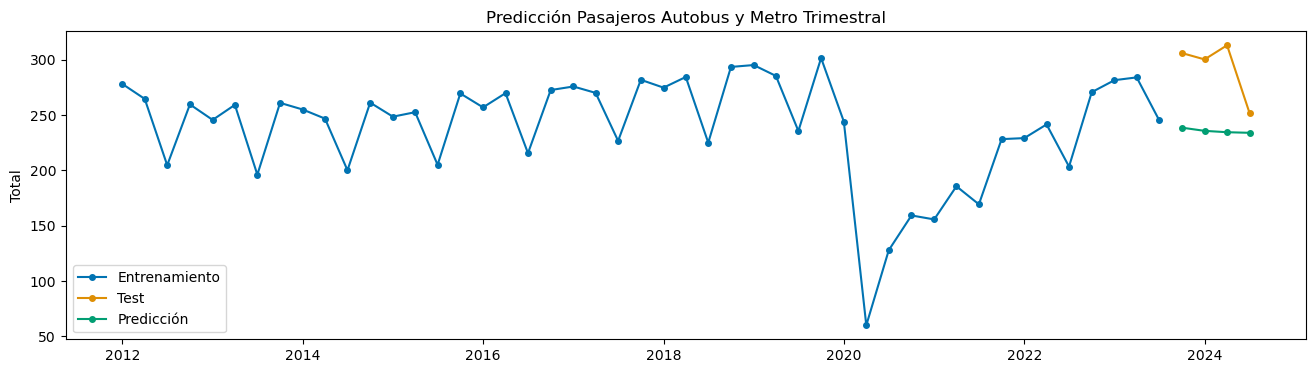

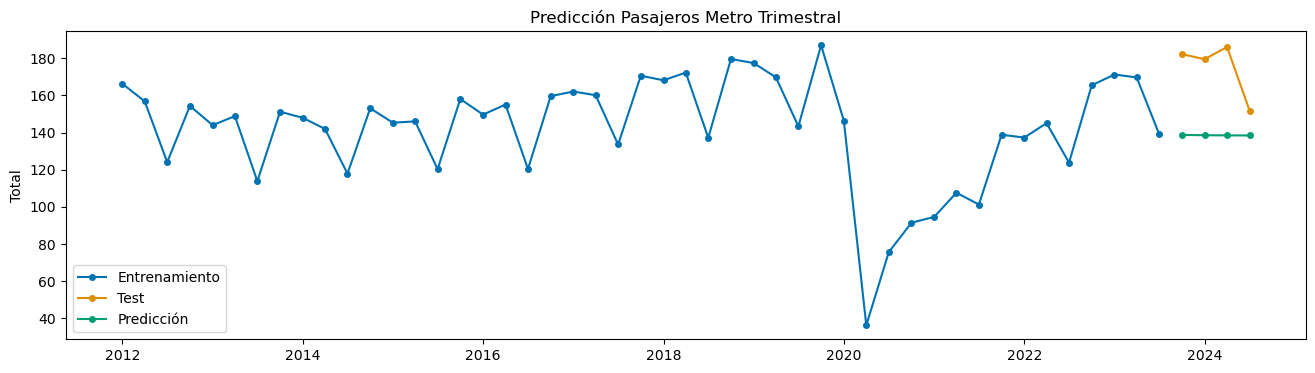

In [17]:
horizon_4_months = 4

# Realizar predicciones y graficar para cada serie temporal trimestral
create_and_forecast_pipeline(df_autobus_trim, sp_params['trimestral'], horizon_4_months, "Predicción Pasajeros Autobus Trimestral")
create_and_forecast_pipeline(df_combined_trim, sp_params['trimestral'], horizon_4_months, "Predicción Pasajeros Autobus y Metro Trimestral")
create_and_forecast_pipeline(df_metro_trim, sp_params['trimestral'], horizon_4_months, "Predicción Pasajeros Metro Trimestral")

La predicción de las series trimestrales no es nada buena en ninguno de los tres casos como podemos observar. El modelo AutoARIMA no consigue detectar el patrón de la serie.

In [20]:
# Crear una función para calcular y mostrar las métricas
def calculate_metrics(y_train, y_test, y_pred, title):
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"{title} - MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

# Calcular y mostrar las métricas para cada serie temporal mensual
y_train, y_test = temporal_train_test_split(df_autobus_month, test_size=horizon_15_months)
pipeline = TransformedTargetForecaster(steps=[
    ("log", LogTransformer()),  # Transformación Log
    ("autoarima", StatsForecastAutoARIMA(sp=sp_params['mensual']))  # Modelo AutoARIMA
])
pipeline.fit(y_train)
fh = np.arange(1, horizon_15_months + 1)
y_pred = pipeline.predict(fh)
calculate_metrics(y_train, y_test, y_pred, "Pasajeros Autobus Mensual")

y_train, y_test = temporal_train_test_split(df_combined_month, test_size=horizon_15_months)
pipeline.fit(y_train)
y_pred = pipeline.predict(fh)
calculate_metrics(y_train, y_test, y_pred, "Pasajeros Autobus y Metro Mensual")

y_train, y_test = temporal_train_test_split(df_metro_month, test_size=horizon_15_months)
pipeline.fit(y_train)
y_pred = pipeline.predict(fh)
calculate_metrics(y_train, y_test, y_pred, "Pasajeros Metro Mensual")

# Calcular y mostrar las métricas para cada serie temporal trimestral
y_train, y_test = temporal_train_test_split(df_autobus_trim, test_size=horizon_4_months)
pipeline = TransformedTargetForecaster(steps=[
    ("log", LogTransformer()),  # Transformación Log
    ("autoarima", StatsForecastAutoARIMA(sp=sp_params['trimestral']))  # Modelo AutoARIMA
])
pipeline.fit(y_train)
fh = np.arange(1, horizon_4_months + 1)
y_pred = pipeline.predict(fh)
calculate_metrics(y_train, y_test, y_pred, "Pasajeros Autobus Trimestral")

y_train, y_test = temporal_train_test_split(df_combined_trim, test_size=horizon_4_months)
pipeline.fit(y_train)
y_pred = pipeline.predict(fh)
calculate_metrics(y_train, y_test, y_pred, "Pasajeros Autobus y Metro Trimestral")

y_train, y_test = temporal_train_test_split(df_metro_trim, test_size=horizon_4_months)
pipeline.fit(y_train)
y_pred = pipeline.predict(fh)
calculate_metrics(y_train, y_test, y_pred, "Pasajeros Metro Trimestral")

Pasajeros Autobus Mensual - MSE: 14.84, RMSE: 3.85, MAPE: 0.08%
Pasajeros Autobus y Metro Mensual - MSE: 201.34, RMSE: 14.19, MAPE: 0.13%
Pasajeros Metro Mensual - MSE: 61.44, RMSE: 7.84, MAPE: 0.12%
Pasajeros Autobus Trimestral - MSE: 536.20, RMSE: 23.16, MAPE: 0.17%
Pasajeros Autobus y Metro Trimestral - MSE: 3798.93, RMSE: 61.64, MAPE: 0.19%
Pasajeros Metro Trimestral - MSE: 1501.83, RMSE: 38.75, MAPE: 0.20%


Al observar las métricas, vemos que la única predicción medianamente aceptable es la predicción de la serie mensual de pasajeros de autobús, con un MAPE del 8% y un RMSE de 385 pasajeros. 

Las demás predicciones no son buenas, probaré con un modelo SARIMA con un componente Autorregresivo de orden 1 (AR=1) y un componente de medias móviles de orden 1 (MA=1).

## Pipeline de Modelos SARIMA

Al igual que con los modelos ARIMA, realizaré un pipeline con los modelos SARIMA. Al final comentaré los resultados tanto visuales como de las métricas de precisión establecidas.

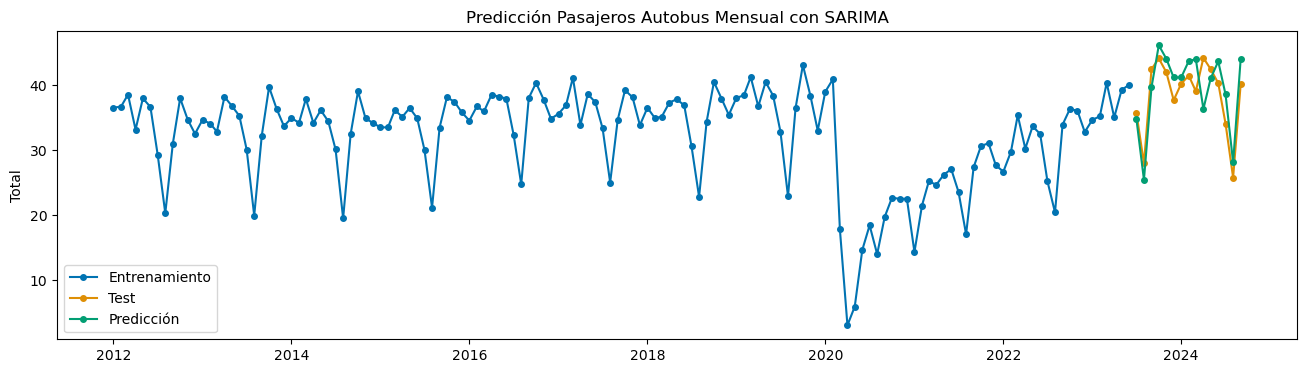

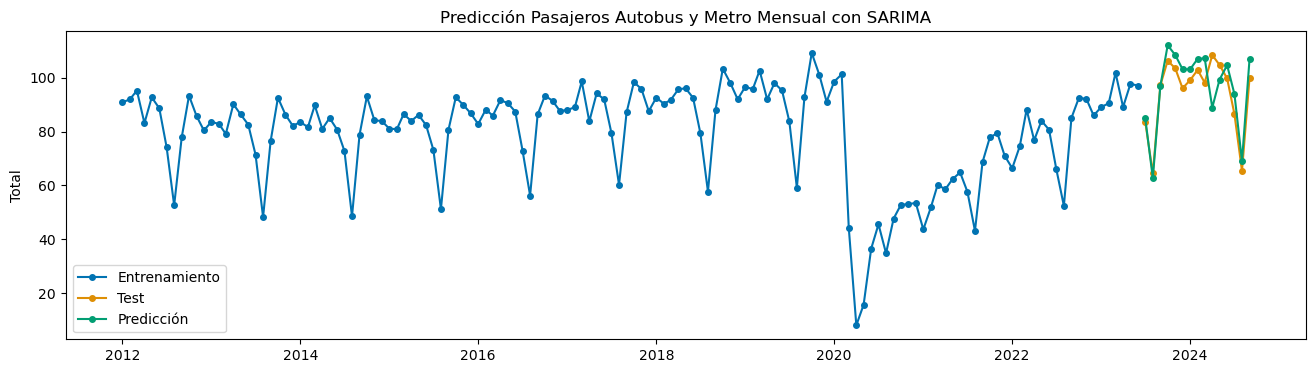

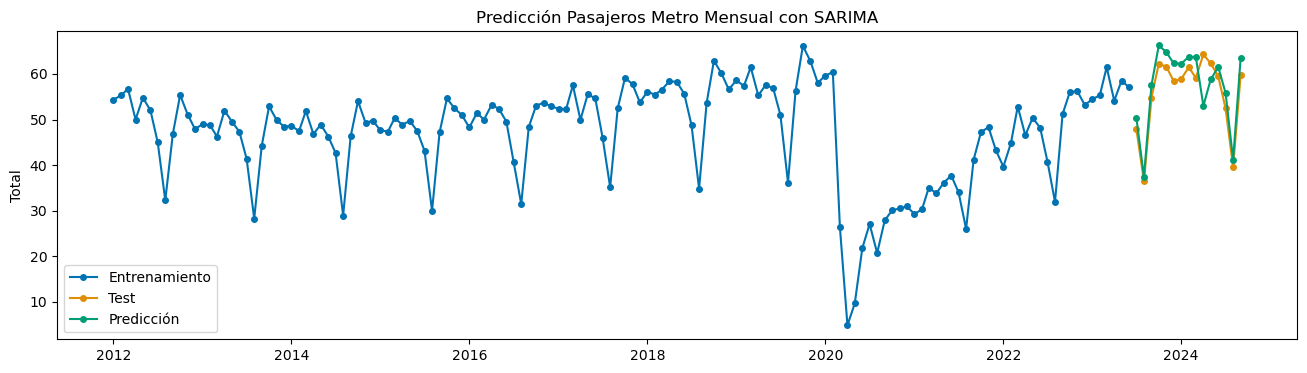

In [27]:
# Crear una función para ajustar el pipeline y predecir usando SARIMA
def create_and_forecast_sarima_pipeline(y, sp, horizon, title):
    y_train, y_test = temporal_train_test_split(y, test_size=horizon)
    pipeline = TransformedTargetForecaster(steps=[
        ("log", LogTransformer()),  # Transformación Log
        ("sarima", SARIMAX(order=(1, 1, 1), seasonal_order=(1, 1, 1, sp)))  # Modelo SARIMA
    ])
    pipeline.fit(y_train)
    fh = np.arange(1, horizon + 1)
    y_pred = pipeline.predict(fh)
    plot_series(y_train, y_test, y_pred, labels=["Entrenamiento", "Test", "Predicción"])
    plt.title(title)
    plt.show()

# Definir el horizonte de predicción para 15 meses
horizon_15_months = 15

# Realizar predicciones y graficar para cada serie temporal mensual
create_and_forecast_sarima_pipeline(df_autobus_month, sp_params['mensual'], horizon_15_months, "Predicción Pasajeros Autobus Mensual con SARIMA")
create_and_forecast_sarima_pipeline(df_combined_month, sp_params['mensual'], horizon_15_months, "Predicción Pasajeros Autobus y Metro Mensual con SARIMA")
create_and_forecast_sarima_pipeline(df_metro_month, sp_params['mensual'], horizon_15_months, "Predicción Pasajeros Metro Mensual con SARIMA")

Visualmente observamos como el modelo SARIMA de orden (1, 1, 1) realiza mejores predicciones que nuestro modelo ARIMA anterior en estas series mensuales, veremos a continuación las trimestrales.

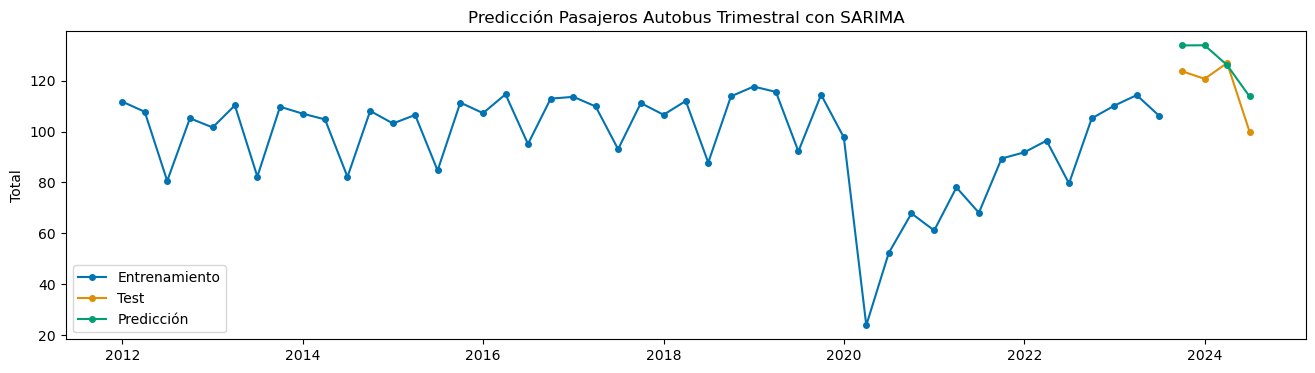

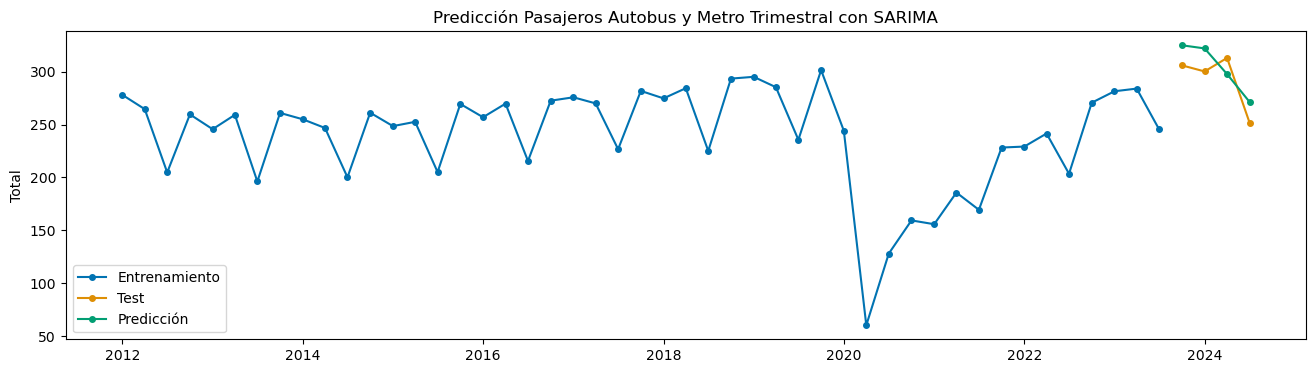

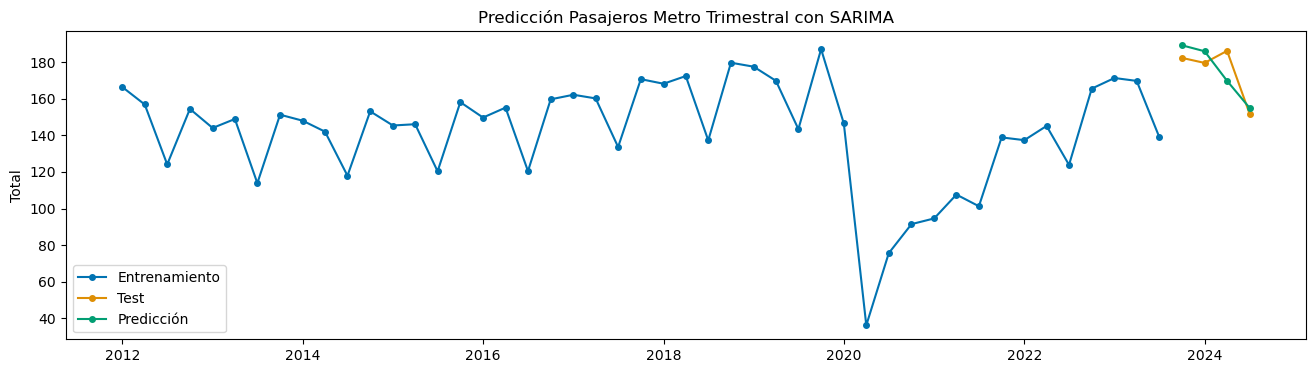

In [26]:
# Realizar predicciones y graficar para cada serie temporal trimestral

create_and_forecast_sarima_pipeline(df_autobus_trim, sp_params['trimestral'], horizon_4_months, "Predicción Pasajeros Autobus Trimestral con SARIMA")
create_and_forecast_sarima_pipeline(df_combined_trim, sp_params['trimestral'], horizon_4_months, "Predicción Pasajeros Autobus y Metro Trimestral con SARIMA")
create_and_forecast_sarima_pipeline(df_metro_trim, sp_params['trimestral'], horizon_4_months, "Predicción Pasajeros Metro Trimestral con SARIMA")

En este caso, en las predicciones trimestrales de este modelo SARIMA se observa una gran mejora en comparación del modelo ARIMA, que no era capaz de detectar la tendencia.

A continuación veremos las métricas de evaluación.

In [28]:
# Crear una función para calcular y mostrar las métricas para SARIMA
def calculate_sarima_metrics(y, sp, horizon, title):
    y_train, y_test = temporal_train_test_split(y, test_size=horizon)
    pipeline = TransformedTargetForecaster(steps=[
        ("log", LogTransformer()),  # Transformación Log
        ("sarima", SARIMAX(order=(1, 1, 1), seasonal_order=(1, 1, 1, sp)))  # Modelo SARIMA
    ])
    pipeline.fit(y_train)
    fh = np.arange(1, horizon + 1)
    y_pred = pipeline.predict(fh)
    calculate_metrics(y_train, y_test, y_pred, title)

# Calcular y mostrar las métricas para cada serie temporal mensual con SARIMA
calculate_sarima_metrics(df_autobus_month, sp_params['mensual'], horizon_15_months, "Pasajeros Autobus Mensual con SARIMA")
calculate_sarima_metrics(df_combined_month, sp_params['mensual'], horizon_15_months, "Pasajeros Autobus y Metro Mensual con SARIMA")
calculate_sarima_metrics(df_metro_month, sp_params['mensual'], horizon_15_months, "Pasajeros Metro Mensual con SARIMA")

# Calcular y mostrar las métricas para cada serie temporal trimestral con SARIMA
calculate_sarima_metrics(df_autobus_trim, sp_params['trimestral'], horizon_4_months, "Pasajeros Autobus Trimestral con SARIMA")
calculate_sarima_metrics(df_combined_trim, sp_params['trimestral'], horizon_4_months, "Pasajeros Autobus y Metro Trimestral con SARIMA")
calculate_sarima_metrics(df_metro_trim, sp_params['trimestral'], horizon_4_months, "Pasajeros Metro Trimestral con SARIMA")

Pasajeros Autobus Mensual con SARIMA - MSE: 12.09, RMSE: 3.48, MAPE: 0.08%
Pasajeros Autobus y Metro Mensual con SARIMA - MSE: 52.18, RMSE: 7.22, MAPE: 0.06%
Pasajeros Metro Mensual con SARIMA - MSE: 17.69, RMSE: 4.21, MAPE: 0.06%
Pasajeros Autobus Trimestral con SARIMA - MSE: 82.87, RMSE: 9.10, MAPE: 0.08%
Pasajeros Autobus y Metro Trimestral con SARIMA - MSE: 314.89, RMSE: 17.75, MAPE: 0.06%
Pasajeros Metro Trimestral con SARIMA - MSE: 86.02, RMSE: 9.27, MAPE: 0.05%


Notamos una gran mejora en estas métricas del modelo SARIMA en comparación con las métricas del modelo ARIMA anterior, aun así, se probarán en siguientes notebooks modelos como ETS, Bats, Theta, etc. Contrastaremos los resultados y finalmente elegiremos el modelo que mejor se adapte en cada caso para cada una de las 6 series temporales.

***

## Conclusión ARIMA

Los resultados muestran que los modelos SARIMA superan consistentemente a los modelos ARIMA en la predicción de pasajeros de autobús y metro en Madrid, tanto a nivel mensual como trimestral. Esto se refleja en menores valores de MSE, RMSE y MAPE en todos los casos, indicando una mayor precisión y menor error relativo. La capacidad de SARIMA para capturar patrones estacionales recurrentes parece ser clave para su mejor desempeño, especialmente en series trimestrales, donde los errores del ARIMA son significativamente mayores. En particular, SARIMA logra un ajuste notablemente más preciso para las series combinadas de autobús y metro, lo que resalta su idoneidad para manejar series temporales con componentes estacionales marcados y múltiples dinámicas.


In [31]:
# Guardar las series temporales en un archivo CSV
df_autobus_month.to_csv('../data/transformed/Madrid_autobus_month.csv', index=True, index_label='Periodo')
df_autobus_trim.to_csv('../data/transformed/Madrid_autobus_trim.csv', index=True, index_label='Periodo')
df_combined_month.to_csv('../data/transformed/Madrid_combined_month.csv', index=True, index_label='Periodo')
df_combined_trim.to_csv('../data/transformed/Madrid_combined_trim.csv', index=True, index_label='Periodo')
df_metro_month.to_csv('../data/transformed/Madrid_metro_month.csv', index=True, index_label='Periodo')
df_metro_trim.to_csv('../data/transformed/Madrid_metro_trim.csv', index=True, index_label='Periodo')